# Week 3 Lab: Capture Data Change with Flink and Debezium

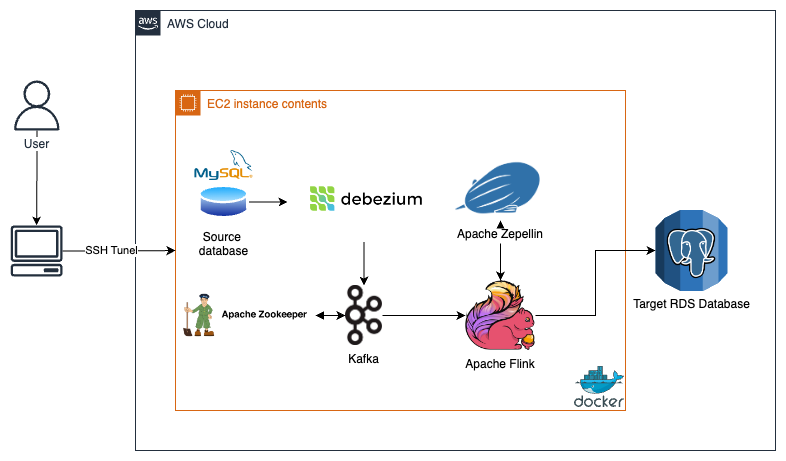


Follow the instructions in this notebook to work with the Flink environment.

## 1 - Configuring the Flink Environment

Start by configuring the Flink enviroment. Run the following cell:

In [2]:
%flink.conf
# You need to run this paragraph first before running any flink code.
flink.execution.packages	org.apache.flink:flink-connector-kafka_2.11:1.14.0,org.apache.flink:flink-connector-kafka-base_2.11:1.11.6,org.apache.flink:flink-json:1.14.0,org.apache.flink:flink-avro-confluent-registry:1.14.0,mysql:mysql-connector-java:8.0.28,org.apache.flink:flink-connector-jdbc_2.11:1.14.6,org.postgresql:postgresql:42.7.3

To test the Interpreters, run the following queries with the `%mysql` and `%psql` interpreters to check the available schemas and tables:

In [4]:
%mysql
show schemas;

In [5]:
%mysql
select table_schema as database_name,
    table_name
from information_schema.tables
where table_type = 'BASE TABLE'
        and table_schema = 'classicmodels'
order by database_name, table_name;

In [6]:
%psql
SELECT schema_name
FROM information_schema.schemata;

In [7]:

%psql
select * from pg_tables where schemaname='classicmodels_star_schema';

## 2 - Customers Dimension

You will use Flink SQL to connect to the Debezium/Kafka topics and create Flink tables on top of them, these topics bring the current values and future changes for each table in the source database. Then you will create Flink tables connecting to the tables in the target database and write the SQL logic to insert from the Source tables into the Output tables.

Before defining the CDC pipeline, review the original `customers` table from the source system, use the `%mysql` interpreter to run the following cell:

In [9]:
%mysql
SELECT * FROM classicmodels.customers limit 10;

### 2.1 - Creating Flink Tables

To create Flink tables with the SQL API, you will use `CREATE` statements that register a table into the current Flink catalog using the `%flink.ssql` Interpreter. You define the schema of the source data and then specify the **connector** format and parameters of the table.

This is an example of a table named `source_customers` with a Kafka topic:

```sql
CREATE TABLE source_customers (
    ...
) WITH (
  'connector' = 'kafka'
  'topic' = '<KAFKA_TOPIC>',
  'properties.bootstrap.servers' = '<KAFKA_SERVER_URL>'
  ...
);
```

The data will be coming from a Kafka topic connected to Debezium and the source system. You will need to use the following configuration parameters for the table connection:

```sql
CREATE TABLE source_customers (
    ...
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.customers',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);
```

2.1.1. In the code cell below add those connection parameters and review the list of the columns. Note, that in this particular case, a metadata column will be added to the original source schema. This allows to access information obtained or produced by the connector, in this case, the timestamp of the Kafka record in the topic. To read and write a Kafka record's timestamp in the additional metadata column, the following code is used:

```sql
`event_time` TIMESTAMP(3) METADATA FROM 'timestamp',
```

In [12]:
%flink.ssql
DROP TABLE IF EXISTS source_customers;

CREATE TABLE source_customers (
    `customerNumber` INT,
    `customerName` STRING,
    `contactLastName` STRING,
    `contactFirstName` STRING,
    `phone` STRING,
    `addressLine1` STRING,
    `addressLine2` STRING,
    `city` STRING,
    `state` STRING,
    `postalCode` STRING,
    `country` STRING,
    `salesRepEmployeeNumber` INT,
    `creditLimit` FLOAT, --VARBINARY,
    `event_time` TIMESTAMP(3) METADATA FROM 'timestamp',
    PRIMARY KEY (`customerNumber`)  NOT ENFORCED
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.customers',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);

2.1.2. To check that the `source_customers` table is well defined, add this table name into the following `SELECT` query and run the cell. After getting some results cancel the query in the upper right of the cell with the pause icon.

In [14]:

%flink.ssql
SELECT *
FROM source_customers;

2.1.3. You can use all types of connectors, for example a JDBC one to connect with SQL databases:

```sql
CREATE TABLE TargetTable (
    ...
) WITH (
  'connector' = 'jdbc',
  'url' = '<JDBC_URL>',
  'table-name' = '<TARGET_SCHEMA>.<TARGET_TABLE>',
  'username' = '<DATABASE_USER>',
  'password' = '<DATABASE_PASSWORD>'
);
```

Let's now define the `dest_customers` output table connecting to an existing table in the Postgres RDS target database, specifically the `classicmodels_star_schema.dim_customers` table. Use this configuration for the target table connection:

```sql
CREATE TABLE dest_customers (
    ...
) WITH (
  'connector' = 'jdbc',
  'url' = 'jdbc:postgresql://<POSTGRES_ENDPOINT>:5432/postgres',
  'table-name' = 'classicmodels_star_schema.dim_customers',
  'username' = 'postgresuser',
  'password' = 'adminpwrd'
); 
```

Exchange the placeholder `<POSTGRES_ENDPOINT>` (including the brackets `<>`) with the `PostgresEndpoint` value from the Cloudformation Output.

In [16]:
%flink.ssql
DROP TABLE IF EXISTS dest_customers;

CREATE TABLE dest_customers (
    `customer_key` INT,
    `customer_name` STRING,
    `customer_last_name` STRING,
    `customer_first_name` STRING,
    `phone` STRING,
    `address_line_1` STRING,
    `address_line_2` STRING,
    `postal_code` STRING,
    `city` STRING,
    `state` STRING,
    `country` STRING,
    `creditlimit` FLOAT,
    `updated_at` TIMESTAMP(3),
     PRIMARY KEY (`customer_key`)  NOT ENFORCED
) WITH (
  'connector' = 'jdbc',
  'url' = 'jdbc:postgresql://de-c4w3lab1-rds.c5y462o64kyl.us-east-1.rds.amazonaws.com:5432/postgres',
  'table-name' = 'classicmodels_star_schema.dim_customers',
  'username' = 'postgresuser',
  'password' = 'adminpwrd'
);

### 2.2 - Moving Data

You can create an INSERT statement to move data from the source table `source_customers` into the output table `dest_customers`. This process will run indefinitely as a Flink Job, constantly reading from the `source_customers` table, and when new data comes, it is inserted in the `dest_customers`.

```sql
INSERT INTO dest_customers 
SELECT
    ...
FROM source_customers;
```

2.2.1. Add the table names into the query below to insert into the `dest_customers` the required data from the `source_customers`.

This will run indefinitely as a Flink Job, so you will keep it running while testing the CDC pipeline. Afterwards, cancel the job using the pause icon in the top right section of the following cell. Wait a few minutes until you see the message: "**Duration:** ... minutes ... seconds". After that you can continue.

In [19]:
%flink.ssql

INSERT INTO dest_customers (customer_key, customer_name, customer_last_name, customer_first_name, phone, address_line_1, address_line_2, postal_code, city, state, country, creditlimit ,updated_at)
SELECT customerNumber, customerName, contactLastName, contactFirstName, phone, addressLine1, addressLine2, postalCode, city, state, country, creditLimit, event_time
FROM source_customers;


2.2.2. To check that the `INSERT` statement is working, specify the table `classicmodels_star_schema.dim_customers` in the queries below. Use the `%psql` Interpreter to run them:

In [21]:
%psql
select * from classicmodels_star_schema.dim_customers limit 10;

In [22]:
%psql
select count(*) from classicmodels_star_schema.dim_customers;

### 2.3 - CDC Process

Now that you can see that data in the destination database has been uploaded, you will see how the CDC process works. 

2.3.1. Insert some new data into the MySQL `customers` table and will see that the data is also inserted automatically in the destination database in PostgreSQL at the `dim_customer` table. Make sure that the insertion cell `INSERT INTO dest_customers` (step 2.2.1.) is also running.

In [25]:
%mysql
INSERT INTO classicmodels.customers (customerNumber, customerName, contactLastName, contactFirstName, phone, addressLine1, addressLine2, city, state, postalCode, country, salesRepEmployeeNumber, creditLimit)
VALUES (498, 'Great Toys', 'Smith', 'Jhon', '1234567', '106 Linden Road Sandown', '4th Floor', 'Singapore', null, 069045, 'Singapore', 1621, 10000 ),
(500, 'Games & Toys', 'Murphy', ' Susan', '987654321', '5540 North Pendale Street', 'Level 2', 'San Francisco', 'CA', 94217, 'USA', 1165, 0.0 ),
(501, 'Scaled Toys Distributors, Ltd.', 'Young', 'Mary', '212557411', '4092 Furth Circle', 'Suite 500', 'NYC', 'NY', 10022, 'USA', 1504, 200000 );

In [26]:
%mysql
SELECT count(*) FROM classicmodels.customers;

2.3.2. Remember to make sure that the insertion cell `INSERT INTO dest_customers` is currently running, otherwise, run it again and then run the following cell to count the number of rows in the `dim_customers` table at the PostgreSQL database.


In [28]:
%psql
select count(*) from classicmodels_star_schema.dim_customers;

You should have seen that the new 3 rows have been inserted. Even if you try to delete or update any of those rows in the MySQL source database, those changes will also be propagated to the destination PostgreSQL table.

2.3.3. Let's delete the customer with customer key `501` as you were told that this company is no longer one of your customers.

In [31]:
%mysql
DELETE FROM classicmodels.customers WHERE customerNumber = 501;

SELECT COUNT(*) FROM classicmodels.customers;

2.3.4. Inspect the result in the `dim_customers` table in PostgreSQL.

In [33]:
%psql
SELECT COUNT(*) FROM classicmodels_star_schema.dim_customers;

You have seen how insertion and deletion processes are propagated from the source system into the destination system through the CDC process. Now, you can stop the `INSERT INTO dest_customers` cell (step 2.2.1.) to release the task. If the cell associated with this command: 

```SQL
SELECT *
FROM source_customers limit 5;
````

is also running (step 2.1.2.), make sure to stop it before continuing with the following section.

## 3 - Products Dimension

Now you will define the pipeline for the `dim_products` dimensional table, review the original `products` and `productlines` table from the source system, use the `%mysql` interpreter to run the following cells:

In [36]:
%mysql
SELECT * FROM classicmodels.products limit 10;

In [37]:
%mysql
SELECT * FROM classicmodels.productlines limit 10;

3.1. Define the input tables `source_products` and `source_productlines` using the `%flink.ssql` Interpreter in the following two cells. As in the previous section, the data will be coming from Kafka topics connected to Debezium and the source system. Use the same configuration as the previous table connection (steps 2.1.1. and 2.1.2.), changing the topics to `dbserver1.classicmodels.products` and `dbserver1.classicmodels.productlines` respectively. Don't forget to add the metadata column `event_time` to each source table.

In [39]:
%flink.ssql
DROP TABLE IF EXISTS source_products;

CREATE TABLE source_products (
    `productCode` STRING,
    `productName` STRING,
    `productLine` STRING,
    `productScale` STRING,
    `productVendor` STRING,
    `productDescription` STRING,
    `quantityInStock` INT,
    `buyPrice` FLOAT,
    `MSRP` FLOAT,
    `event_time` TIMESTAMP(3) METADATA FROM 'timestamp',
    PRIMARY KEY (`productCode`) NOT ENFORCED
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.products',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);


In [40]:
%flink.ssql
DROP TABLE IF EXISTS source_productlines;

CREATE TABLE source_productlines (
    `productLine` STRING,
    `textDescription` STRING,
    `event_time` TIMESTAMP(3) METADATA FROM 'timestamp',
    PRIMARY KEY (`productLine`) NOT ENFORCED
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.productlines',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);


3.2. Define the `dest_products` table, this will point to the Postgres RDS target database, specifically the `classicmodels_star_schema.dim_products` table. Exchange the placeholder `<POSTGRES_ENDPOINT>` (including the brackets `<>`) with the `PostgresEndpoint` value from the Cloudformation Output and all of the `None` with the required values.

In [42]:
%flink.ssql
DROP TABLE IF EXISTS dest_products;

CREATE TABLE dest_products (
    `product_key` STRING,
	`product_name` STRING,
	`product_line` STRING,
	`product_scale` STRING,
	`product_vendor` STRING,
	`product_description` STRING,
	`product_line_description` STRING,
	`updated_at` TIMESTAMP(3),
     PRIMARY KEY (`product_key`)  NOT ENFORCED
) WITH (
  'connector' = 'jdbc',
  'url' = 'jdbc:postgresql://de-c4w3lab1-rds.c5y462o64kyl.us-east-1.rds.amazonaws.com:5432/postgres',
  'table-name' = 'classicmodels_star_schema.dim_products',
  'username' = 'postgresuser',
  'password' = 'adminpwrd'
);

3.3. Now, you will insert into the `dest_products` the required data from joining the `source_products` and `dest_productlines` tables, this will run indefinitely as a Flink Job, so we will keep it running while testing the CDC pipeline. Afterwards, cancel the job using the pause icon in the top right section of the following cell. Wait a few minutes until you see the message: "**Duration:** ... minutes ... seconds". After that you can continue.

In [44]:
%flink.ssql

INSERT INTO dest_products (product_key, product_name, product_line, product_scale, product_vendor, product_description, product_line_description, updated_at)
SELECT sp.productCode, sp.productName, sp.productLine, sp.productScale, sp.productVendor, sp.productDescription, spl.textDescription, sp.event_time
FROM source_products AS sp
JOIN source_productlines AS spl on sp.productLine = spl.productLine
;


3.4. Let's check that the `INSERT` statement is working. Use the %psql Interpreter to run the following cells:

In [46]:
%psql
select * from classicmodels_star_schema.dim_products limit 10;

In [47]:
%psql
select count(*) from classicmodels_star_schema.dim_products;

3.5. Now, let's insert and delete some rows into the `products` table in the MySQL source database and see how those changes are propagated into the PostgreSQL database through the CDC process. Currently, there are 110 products in the source database. Let's insert some new products. Wait a few minutes until you see the message: "**Duration:** ... minutes ... seconds". After that you can continue.

In [49]:
%mysql
INSERT INTO classicmodels.products (productCode, productName, productLine, productScale, productVendor, productDescription, quantityInStock, buyPrice, MSRP)
VALUES  ('S700_5000', 'Santisima Trinidad', 'Ships', '1:700', 'Autoart Studio Design', 'All wood with canvas sails. Measures 31 1/2 inches in Length, 22 inches High and 4 3/4 inches Wide. Many extras. Was a Spanish first-rate ship of the line and was the largest warship in the world when launched on 1769.', 500, 40.0, 75.0),
('S700_5001', 'Couronne', 'Ships', '1:700', 'Unimax Art Galleries', 'Measures 30 inches Long x 27 1/2 inches High x 4 3/4 inches Wide.  Many extras including rigging, long boats, pilot house, anchors, etc. Comes with three masts, all square-rigged.', 10, 31.2, 50.0);

In [50]:
%mysql
SELECT count(*) FROM classicmodels.products;

3.6. With the new two rows inserted, let's check the `dim_products` dimension table at PostgreSQL. Remember that the cell performing the `INSERT INTO dest_products` command (step 3.3.) should be running before executing the following cell:

In [52]:
%psql
SELECT count(*) FROM classicmodels_star_schema.dim_products;

3.7. Now, it seems like the information provided for the product with code `'S700_5001'` was incorrect and the actual `productScale` is `'1:500'` and the actual `productVendor` is `'Autoart Studio Design'`. Let's perform an update process in the MySQL table and check the result in PostgreSQL:

In [54]:
%mysql
UPDATE classicmodels.products
SET productScale = '1:500', productVendor = 'Autoart Studio Design'
WHERE productCode='S700_5001';

SELECT * FROM classicmodels.products WHERE productCode='S700_5001';

In [55]:
%psql
SELECT * FROM classicmodels_star_schema.dim_products WHERE product_key='S700_5001';

You have seen in this example how the CDC process is able to take into account the updates performed in the sources system and propagate them into the destination system. Remember to stop the `INSERT INTO dest_products` process (step 3.3.) above before continuing with the next section in order to release the Flink's task slots.

## 4 - Fact Table

Finally, you will define the pipeline for the `fact_orders` fact table, review the original `orders` and `orderdetails` table from the source system, use the `%mysql` interpreter to run the following cells:

In [58]:
%mysql
SELECT * FROM classicmodels.orders limit 10;

In [59]:
%mysql
SELECT * FROM classicmodels.orderdetails limit 10;

4.1. Define the input tables `source_orders` and `source_orderdetails` using the `%flink.ssql` Interpreter. As in the previous sections, use a similar configuration as the previous table connections, just change the topics to `dbserver1.classicmodels.orders` and `dbserver1.classicmodels.orderdetails` respectively. There will be the same metadata column `event_time` added to each source table.

In [61]:
%flink.ssql
DROP TABLE IF EXISTS source_orders;

CREATE TABLE source_orders (
    orderNumber INT,
    orderDate BIGINT,
    requiredDate BIGINT,
    shippedDate BIGINT,
    status STRING,
    comments STRING,
    customerNumber INT,
    event_time TIMESTAMP(3) METADATA FROM 'timestamp',
    PRIMARY KEY ( orderNumber) NOT ENFORCED
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.orders',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);


In [62]:
%flink.ssql
DROP TABLE IF EXISTS source_orderdetails;

CREATE TABLE source_orderdetails (
`orderNumber` INT,
`productCode` STRING,
`quantityOrdered` INT,
`priceEach` FLOAT,
`orderLineNumber` INT,
`event_time` TIMESTAMP(3) METADATA FROM 'timestamp',
  PRIMARY KEY ( orderNumber, productCode) NOT ENFORCED
) WITH (
  'connector' = 'kafka',
  'topic' = 'dbserver1.classicmodels.orderdetails',
  'properties.bootstrap.servers' = 'kafka:9092',
  'properties.group.id' = 'testGroup',
  'format' = 'debezium-json',
  'scan.startup.mode' = 'earliest-offset',
  'debezium-json.schema-include' = 'true'
);


4.2. Define the `dest_factorders` table, this will point to the Postgres RDS target database, specifically the `classicmodels_star_schema.fact_orders` table. Change the placeholder `<POSTGRES_ENDPOINT>` (including the brackets `<>`) with the `PostgresEndpoint` value from the Cloudformation Output and all of the `None`s with the required values.

In [64]:
%flink.ssql
DROP TABLE IF EXISTS dest_factorders;

CREATE TABLE dest_factorders (
    order_key INT,
    order_line_key INT,
    customer_key INT,
    product_key STRING,
    order_date BIGINT,
    order_required_date BIGINT,
    order_shipped_date BIGINT,
    quantity_ordered INT,
    product_price FLOAT,
    profit FLOAT,
    updated_at TIMESTAMP(3),
    PRIMARY KEY ( order_key, order_line_key, customer_key, product_key) NOT ENFORCED
) WITH (
  'connector' = 'jdbc',
  'url' = 'jdbc:postgresql://de-c4w3lab1-rds.c5y462o64kyl.us-east-1.rds.amazonaws.com:5432/postgres',
  'table-name' = 'classicmodels_star_schema.fact_orders',
  'username' = 'postgresuser',
  'password' = 'adminpwrd'
);


4.3. Run the `INSERT` query that creates the fact table, there is a field called `profit` that is calculated by subtracting from the price of each product the price for what the product was bought. Wait a moment until you see the message:
**Duration:** and the counter has measured a few seconds before you can continue.

In [66]:
%flink.ssql

INSERT INTO dest_factorders (order_key, order_line_key, customer_key, product_key, order_date, order_required_date, order_shipped_date, quantity_ordered, product_price, profit, updated_at)
SELECT so.orderNumber, sod.orderLineNumber, so.customerNumber, sod.productCode, so.orderDate, so.requiredDate, so.shippedDate, sod.quantityOrdered, sod.priceEach, (sod.priceEach - sp.buyPrice) * sod.quantityOrdered, so.event_time
FROM source_orders AS so
JOIN source_orderdetails AS sod ON so.orderNumber = sod.orderNumber
JOIN source_products AS sp ON sod.productCode = sp.productCode
;


4.4. Let's check that the `INSERT` statement is working. Use the `%psql` Interpreter to run the following cells:

In [68]:
%psql
select * from classicmodels_star_schema.fact_orders limit 10;

In [69]:
%psql
select count(*) from classicmodels_star_schema.fact_orders;

4.5. Before finishing the lab, remember to stop the cell associated with the process: `INSERT INTO dest_factorders` (step 4.3.).

In this lab, you explored the implementation of Change Data Capture (CDC) using Apache Flink and Debezium. The combination of Debezium and Flink offers a powerful solution for capturing and processing data changes, making it easier to maintain consistency and derive insights from continuously evolving datasets.